In [39]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import math
import gtsam
import gtsam.utils.plot
import itertools


In [40]:
siftPts = namedtuple('siftPts', 'k d')
def siftDC(img):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    # take in source and destinatition photos and outputs sift detected key points and computed descriptors as an array
    sift = cv2.SIFT_create(nfeatures=4000,
                                   nOctaveLayers=6,
                                   contrastThreshold=0.025,
                                   sigma=1.5) #create our detector
    keypoints, descriptors = sift.detectAndCompute(img,None) # detect keypoints and compute descriptors

    return siftPts(keypoints,descriptors)

In [41]:
def matchMaker(d1,d2,pts):
    # takes in keypoints and descriptors for two images and returns a sorted index of matches using bfmatcher
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # matches = bf.match(d1,d2)
    # matches = sorted(matches, key = lambda x:x.distance)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    

    # Apply ratio test
    good = []
    goodmatch = 0
    ratio = 0.1
    while goodmatch <= pts:
        for m in matches:
            if m[0].distance < ratio*m[1].distance:
                good.append(m[0])
                goodmatch +=1
        ratio += .1

    good = sorted(good, key = lambda x:x.distance)

    return matches, good

In [48]:

def getFun(dest_kp, src_kp,good): # find fundamental matrix, works in much the same way as finding H

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good])
    p = np.array([0,0,0,0,0,0,0,0,1])    

    F, mask = cv2.findFundamentalMat(dest,src,cv2.FM_RANSAC)
    return F, mask

 


In [78]:
# Lets start by making a function to load in our images and detect features, storing what we find for later
Graphbin = namedtuple('Graphbin', 'im pts')
def gtloader(folder):
    im_paths = []
    for file in os.listdir(folder):
        if ".png" in file:
            im_paths.append(os.path.join(folder,file))
            # print(im_paths)

    # now lets find features for each image and put them in a list
    imgsAndPts=[]
    im_paths.sort()
    for image in im_paths:
        img = cv2.imread(image)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0,0), fx=1, fy=1)
        imgsAndPts.append(Graphbin(img,siftDC(img)))

    # im_height, im_width = ims[0].shape[:2]
    # # get center point of image, this is our "pose"
    # cam_matrix = np.array([[1, 0, im_width/2], 
    #                       [0, 1, im_height/2],
    #                       [0, 0, 1]])

    return imgsAndPts

In [79]:
buddha=gtloader("./buddha_images")


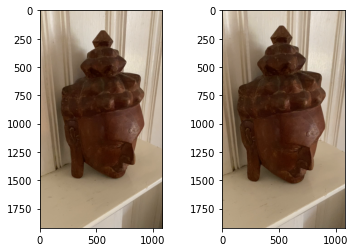

In [104]:
plt.subplot(121), plt.imshow(buddha[4].im)
plt.subplot(122), plt.imshow(buddha[5].im)
plt.show()

In [108]:
matches, good = matchMaker(buddha[4].pts.d,buddha[5].pts.d,4000)
imgLeft = buddha[4].im
imgRight = buddha[5].im

F, mask, ptsLeft, ptsRight= getFun(buddha[4].pts.k,buddha[5].pts.k,good)
print(F)
ptsLeft = np.int32(ptsLeft)
ptsRight = np.int32(ptsRight)
# We select only inlier points
ptsLeft = ptsLeft[mask.ravel() == 1]
ptsRight = ptsRight[mask.ravel() == 1]

[[ 1.97520322e-06 -4.03969173e-05  1.45835968e-02]
 [ 3.56050953e-05  1.26909499e-06  4.35875104e-03]
 [-1.24550908e-02 -7.56785187e-03  1.00000000e+00]]


In [109]:
def drawlines(img1, img2, lines, pts1, pts2):

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
      
    for r, pt1, pt2 in zip(lines, pts1, pts2):
          
        color = tuple(np.random.randint(0, 255,
                                        3).tolist())
          
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1, 
                        (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,
                          tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, 
                          tuple(pt2), 5, color, -1)
    return img1, img2

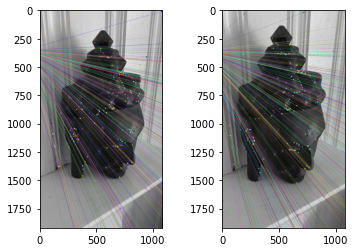

In [110]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1,
                                                           1,
                                                           2),
                                          2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(imgLeft, imgRight, 
                       linesLeft, ptsLeft,
                       ptsRight)
   
# Find epilines corresponding to 
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 
                                           1, F)
linesRight = linesRight.reshape(-1, 3)
  
img3, img4 = drawlines(imgRight, imgLeft, 
                       linesRight, ptsRight,
                       ptsLeft)
   
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

In [103]:

proj = np.vstack(F)
print(ptsRight)
cv2.triangulatePoints()

[[ 192   36]
 [ 121 1388]
 [ 121 1388]
 ...
 [ 572 1175]
 [ 840  810]
 [ 823 1137]]


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'triangulatePoints'
> Overload resolution failed:
>  - triangulatePoints() missing required argument 'projMatr1' (pos 1)
>  - triangulatePoints() missing required argument 'projMatr1' (pos 1)
